In [2]:
import tensorflow as tf
import keras
from keras import layers
import numpy as np
from PIL import Image
import glob

2022-11-26 21:39:03.927125: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-26 21:39:05.275228: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-11-26 21:39:05.275297: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2022-11-26 21:39:05.275304: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

In [107]:
filelist = glob.glob('data/pets/*.jpg')
#x_pets = np.asarray([np.asarray((Image.open(fname).resize((256,256)))) for fname in filelist])

x_pets = []
for file_name in filelist:
    img = Image.open(file_name).convert('RGB')
    img = img.resize((256,256))
    x_pets.append(np.array(img))


x_pets = np.asarray(x_pets)

In [88]:
filelist = glob.glob('data/vangogh/*.jpg')
x_vangogh = np.asarray([np.asarray(Image.open(fname).resize((256,256))) for fname in filelist])

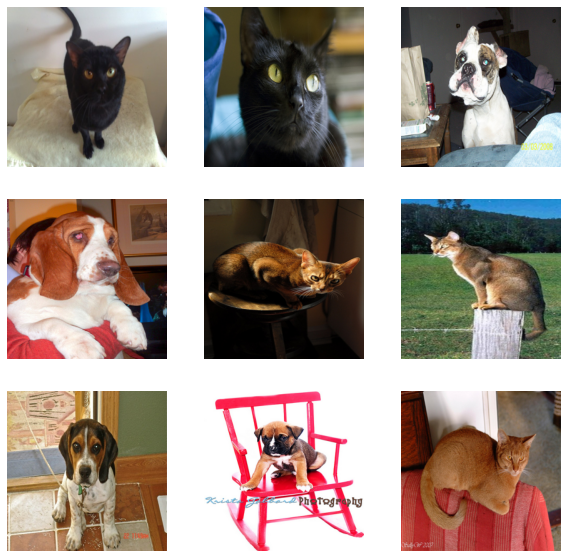

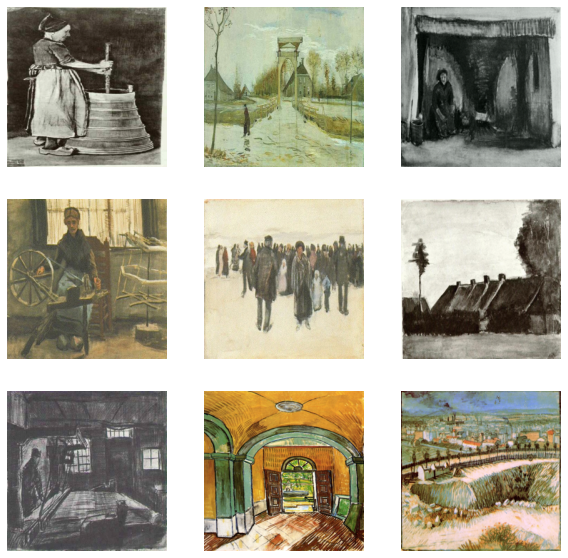

In [108]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(np.array(x_pets[i]).astype("uint8"))
    plt.axis("off")

plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(np.array(x_vangogh[i]).astype("uint8"))
    plt.axis("off")

In [74]:
def noise(array):
    """
    Adds random noise to each image in the supplied array.
    """

    noise_factor = 0.5
    noisy_array = array + noise_factor * np.random.normal(
        loc=0.0, scale=1.0, size=array.shape
    )

    return np.clip(noisy_array, 0.0, 1.0)

[[[115 142 224]
  [112 139 209]
  [102 125 199]
  ...
  [ 97  91  72]
  [ 97  92  73]
  [ 98  93  74]]

 [[124 147 226]
  [127 150 232]
  [119 148 229]
  ...
  [ 98  93  74]
  [101  96  77]
  [102  97  78]]

 [[111 143 218]
  [124 151 231]
  [128 157 230]
  ...
  [ 98  95  76]
  [ 99  95  76]
  [100  96  77]]

 ...

 [[ 11  10  14]
  [ 13  13  16]
  [ 14  14  17]
  ...
  [191 197 211]
  [190 197 213]
  [190 197 213]]

 [[ 11  11  15]
  [ 11  11  15]
  [ 13  12  15]
  ...
  [189 195 211]
  [189 196 213]
  [189 196 214]]

 [[  9   9  13]
  [ 11  10  14]
  [ 13  13  16]
  ...
  [188 194 212]
  [187 194 212]
  [189 196 214]]]


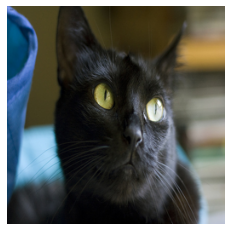

In [118]:
plt.imshow(x_pets[1])
plt.axis("off")
print(x_pets[1])

In [119]:
van_gogh_validator = keras.Sequential([
    layers.Input(shape=(None, None, 3)),
    layers.Conv2D(3, (1, 1), activation='relu', padding='same'),
    layers.MaxPooling2D(),

    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D(),
    layers.Conv2D(1, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D(),

    layers.Flatten(),
    layers.Reshape(target_shape=(1, 1)),
    layers.Dense(1, activation='sigmoid')
])
van_gogh_validator.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, None, None, 3)     12        
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, None, None, 3)    0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, None, None, 128)   3584      
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, None, None, 128)  0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, None, None, 64)    73792     
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, None, None, 64)  

In [120]:
transformer_pets_to_van_gogh = keras.Sequential([
    layers.Dense(32, input_shape=(None, None, 3), name='layer_dense'),
    layers.Conv2DTranspose(32, (3,3), strides=2, activation='relu', padding='same', name='first_conv2D'),
    layers.Conv2DTranspose(64, (3,3), strides=2, activation='relu', padding='same', name='second_conv2D'),
    layers.Conv2DTranspose(3, (3,3), strides=1, activation='relu', padding='same', name='third_conv2D'),
])
transformer_pets_to_van_gogh.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer_dense (Dense)         (None, None, None, 32)    128       
                                                                 
 first_conv2D (Conv2DTranspo  (None, None, None, 32)   9248      
 se)                                                             
                                                                 
 second_conv2D (Conv2DTransp  (None, None, None, 64)   18496     
 ose)                                                            
                                                                 
 third_conv2D (Conv2DTranspo  (None, None, None, 3)    1731      
 se)                                                             
                                                                 
Total params: 29,603
Trainable params: 29,603
Non-trainable params: 0
__________________________________________________

In [121]:
# Générateur
transformer_pets_to_van_gogh.compile(loss="binary_crossentropy", optimizer="adam")
# Discriminator
van_gogh_validator.compile(loss="binary_crossentropy", optimizer="adam")

In [122]:
van_gogh_validator.trainable=False

z = keras.layers.Input(shape=(None,None,3))
image = transformer_pets_to_van_gogh(z)

valid = van_gogh_validator(image)

combined_network = keras.Model(z,valid)
combined_network.compile(loss='binary_crossentropy',optimizer='adam')


In [123]:
print(len(x_pets))

1795


1/1 [==============================] - 1s 709ms/step


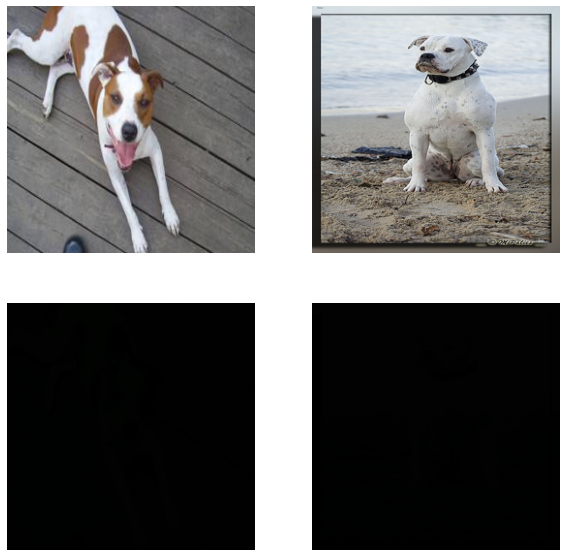

In [124]:
import random

def display_images():
    r, c = 2, 2

    index = np.random.randint(0, len(x_pets), c)
    pets_images = [x.tolist() for x in x_pets[index]]


    generated_images = transformer_pets_to_van_gogh.predict(pets_images)

    #Scaling the generated images
    generated_images = 0.5 * generated_images + 0.5

    plt.figure(figsize=(10, 10))
    for i in range(c):
        ax = plt.subplot(r, c, i + 1)
        plt.imshow(np.array(pets_images[i]).astype("uint8"))
        plt.axis("off")

    for i in range(c):
        ax = plt.subplot(r, c, c + i + 1)
        plt.imshow(np.array(generated_images[i]).astype("uint8"))
        plt.axis("off")

    plt.show()
    plt.close()


display_images()

In [131]:
num_epochs = 5
batch_size = 1

valid = np.ones((256,256, 3))
fake = np.zeros((256,3))

display_interval = 1
valid = 0.05 * np.random.random(valid.shape)
fake = np.zeros((batch_size, 1))
fake += 0.05 * np.random.random(fake.shape)
for epoch in range(num_epochs):

    index = np.random.randint(0, len(x_pets), batch_size)
    pets_images = [x.tolist() for x in x_pets[index]]

    vangogh_index =  np.random.randint(0, x_vangogh.shape[0], batch_size)
    vangogh_images = [x for x in x_vangogh[vangogh_index]]

    generated_images = transformer_pets_to_van_gogh.predict(pets_images)
    discm_loss_real = van_gogh_validator.train_on_batch(vangogh_images, valid)
    discm_loss_fake = van_gogh_validator.train_on_batch(generated_images, fake)

    genr_loss=combined_network.train_on_batch(noise,valid)



    if epoch % display_interval == 0:
        print("EPOCH === ", epoch)
        print('Generator loss = ', genr_loss)
        print('Discriminator_loss = ', discm_loss_fake)
        display_images()


1/1 [==============================] - 0s 418ms/step


ValueError: in user code:

    File "/home/mithrandir/venv/lib/python3.10/site-packages/keras/engine/training.py", line 1249, in train_function  *
        return step_function(self, iterator)
    File "/home/mithrandir/venv/lib/python3.10/site-packages/keras/engine/training.py", line 1233, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/mithrandir/venv/lib/python3.10/site-packages/keras/engine/training.py", line 1222, in run_step  **
        outputs = model.train_step(data)
    File "/home/mithrandir/venv/lib/python3.10/site-packages/keras/engine/training.py", line 1023, in train_step
        y_pred = self(x, training=True)
    File "/home/mithrandir/venv/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/home/mithrandir/venv/lib/python3.10/site-packages/keras/engine/input_spec.py", line 250, in assert_input_compatibility
        raise ValueError(

    ValueError: Exception encountered when calling layer 'sequential_7' (type Sequential).
    
    Input 0 of layer "conv2d_12" is incompatible with the layer: expected min_ndim=4, found ndim=3. Full shape received: (256, 256, 3)
    
    Call arguments received by layer 'sequential_7' (type Sequential):
      • inputs=('tf.Tensor(shape=(256, 256, 3), dtype=uint8)',)
      • training=True
      • mask=None
